Ravi, Xiong, and Howard<br>
CS 6140: Machine Learning<br>
Northeastern University<br>
March 27, 2023

## HW 6: Comprehensive Supervised Learning

### 0. Imports and data clean up

##### 0.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Deliver with style
plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 
sns.set(rc={'figure.figsize':(11,8)})
pd.options.display.float_format = '{:.2f}'.format

##### 0.2 Read the data

In [2]:
# Read data from csv
df19 = pd.read_csv('data/brfss19.csv', usecols = range(1, 250))
df21 = pd.read_csv('data/brfss21.csv', usecols = range(1, 250))

# Shape of the dataframes
print(df19.shape)
print(df21.shape)

(418268, 249)
(438693, 249)


In [3]:
df19.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3
0,1,1,1182019,1,18,2019,1100,2019000001,2019000001,1.00,...,200.00,114.00,1,1,1,1,0,0,2.00,1.00
1,1,1,1132019,1,13,2019,1100,2019000002,2019000002,1.00,...,100.00,121.00,1,1,1,1,0,0,1.00,1.00
2,1,1,1182019,1,18,2019,1100,2019000003,2019000003,1.00,...,114.00,164.00,1,1,1,1,0,0,1.00,2.00
3,1,1,1182019,1,18,2019,1200,2019000004,2019000004,1.00,...,NaN,NaN,9,9,1,1,1,1,9.00,9.00
4,1,1,1042019,1,4,2019,1100,2019000005,2019000005,1.00,...,143.00,178.00,1,1,1,1,0,0,2.00,1.00


In [4]:
df21.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_MISVEG1,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1
0,1.00,1.00,b'01192021',b'01',b'19',b'2021',1100.00,b'2021000001',2021000001.00,1.00,...,0.00,1.00,1.00,100.00,214.00,1.00,1.00,1.00,1.00,0.00
1,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000002',2021000002.00,1.00,...,0.00,1.00,1.00,100.00,128.00,1.00,1.00,1.00,1.00,0.00
2,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000003',2021000003.00,1.00,...,0.00,1.00,1.00,100.00,71.00,1.00,2.00,1.00,1.00,0.00
3,1.00,1.00,b'01172021',b'01',b'17',b'2021',1100.00,b'2021000004',2021000004.00,1.00,...,0.00,1.00,1.00,114.00,165.00,1.00,1.00,1.00,1.00,0.00
4,1.00,1.00,b'01152021',b'01',b'15',b'2021',1100.00,b'2021000005',2021000005.00,1.00,...,0.00,1.00,1.00,100.00,258.00,1.00,1.00,1.00,1.00,0.00


##### 0.3 Align the dataframes

In [5]:
# Compare the different column names in the two data frame
(set(df19.columns) | set(df21.columns)) - (set(df19.columns) & set(df21.columns))

{'CHCCOPD2', 'CHCCOPD3', 'INCOME2', 'INCOME3', '_AIDTST4', '_VEGETE1'}

* The dataframes diverge in only two response column names, which are 'CHCCOPD2' and 'CHCCOPD3'.
* Since the two names stand for the same thing, we will rename both of these columns df21['CHCCOPD3'] and df19['CHCCOPD2] as 'COPD'.
* For 'INCOME2' and 'INCOME3' we will also rename and preserve as 'INCOME2'.
* We will drop '_AIDTST4' and '_VEGETE1' entirely.

In [6]:
# Renaming the columns to match each other
df21.rename(columns = {'CHCCOPD3':'COPD'}, inplace = True)
df19.rename(columns = {'CHCCOPD2':'COPD'}, inplace = True)

In [7]:
# Renaming INCOME3 of df21 to INCOME2 to match with df19
df21.rename(columns = {'INCOME3' : 'INCOME2'}, inplace = True)

In [8]:
# Dropping _AIDTST4 and _VEGETE1
df21 = df21.drop('_AIDTST4', axis=1)
df19 = df19.drop('_VEGETE1', axis=1)

In [9]:
# Confirming no issue
print(set(df21.columns) - set(df19.columns))
for column in df21.columns:
    if column not in set(df19.columns):
        print(column)
for column in df19.columns:
    if column not in set(df21.columns):
        print(column)

set()


##### 0.4 Combine the dataframes

In [10]:
# Now the two df has the same column names, we can concat the two df.
df = pd.concat([df19, df21], ignore_index=True, sort=False)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_FLSHOT7,_PNEUMO3
0,1.00,1.00,1182019,1,18,2019,1100.00,2019000001,2019000001.00,1.00,...,1.00,200.00,114.00,1.00,1.00,1.00,1.00,0.00,2.00,1.00
1,1.00,1.00,1132019,1,13,2019,1100.00,2019000002,2019000002.00,1.00,...,1.00,100.00,121.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00
2,1.00,1.00,1182019,1,18,2019,1100.00,2019000003,2019000003.00,1.00,...,1.00,114.00,164.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00
3,1.00,1.00,1182019,1,18,2019,1200.00,2019000004,2019000004.00,1.00,...,0.00,NaN,NaN,9.00,9.00,1.00,1.00,1.00,9.00,9.00
4,1.00,1.00,1042019,1,4,2019,1100.00,2019000005,2019000005.00,1.00,...,1.00,143.00,178.00,1.00,1.00,1.00,1.00,0.00,2.00,1.00


### 1. Identifying the response variables and the feature space

Prepare the compound response variables:
* Depression: df['ADDEPEV3']
* Ever Told Asthma: df['_CASTHM1']
* Copd: df['COPD']
* Cancer: df['CHCSCNCR'], df['CHCOCNCR']
* Ever Told Heart Condition: df['CVDCRHD4'], df['CVDINFR4'], df['CVDSTRK3']
* Diabetes: df['DIABETE4']<br>

Then handle missing values and prepare the dataframe for analysis.<br>

##### 1.1 'Inclusive or' for cancers and cardiovascular diseases

In [11]:
# For cancer, we need to combine df['CHCSCNCR'] and f['CHCOCNCR']
print(df['CHCSCNCR'].unique())
print(df['CHCOCNCR'].unique())

[ 2.  1. nan  7.  9.]
[ 2.  1.  9.  7. nan]


Per the Codebook Report, only 1 stands for diagnosed. If either column shows 1, then the combined column is 1. Otherwise, we use 0 to stand for not diagnosed.

In [12]:
# Combine two different types of cancer into one feature
has_cncr = (df['CHCSCNCR'] == 1) | (df['CHCOCNCR'] == 1)
df['CNCR'] = has_cncr.astype(int)
df['CNCR'].value_counts()

0    708342
1    148619
Name: CNCR, dtype: int64

In [13]:
# Combine three different cardio-vascular condition into one feature
has_cvd = (df["CVDCRHD4"] == 1) | (df["CVDINFR4"] == 1) | (df["CVDSTRK3"] == 1) 
df["CVD"] = has_cvd.astype(int)
df["CVD"].value_counts() 

0    761194
1     95767
Name: CVD, dtype: int64

In [14]:
# print the percentage of unique values for cancer and heart condition
print(df['CNCR'].value_counts() / len(df['CNCR']))
print(df['CVD'].value_counts() / len(df['CVD']))

0   0.83
1   0.17
Name: CNCR, dtype: float64
0   0.89
1   0.11
Name: CVD, dtype: float64


Before creating the two additional categorical columns, we need to clean the NaN values in the chronic condition columns.

##### 1.2 Handling missing response values

In [15]:
chronic_df = df[['ADDEPEV3', '_CASTHM1', 'COPD', 'CHCSCNCR', 'CHCOCNCR', 'CNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'CVD', 'DIABETE4']]
print(chronic_df.shape)

(856961, 11)


In [16]:
# Missing value analysis in the chronic_df
# list all the columns and number of missing values in that column
missing_cols = chronic_df.isna().sum().reset_index()
missing_cols

,index,0
0,ADDEPEV3,13
1,_CASTHM1,0
2,COPD,11
3,CHCSCNCR,10
4,CHCOCNCR,12
5,CNCR,0
6,CVDCRHD4,10
7,CVDINFR4,12
8,CVDSTRK3,13
9,CVD,0


Seeing that there are only few missing values in these columns (<0.1%), we simply drop the associated rows.

In [17]:
df.dropna(subset=['ADDEPEV3', '_CASTHM1', 'COPD', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DIABETE4'], inplace=True)

##### 1.3 Handling missing feature values

In [18]:
chronic_conditions = ['ADDEPEV3', '_CASTHM1', 'COPD', 'CNCR', 'CVD', 
    'DIABETE4']

In [19]:
missing_values_cols = df.isna().sum()
missing_values_cols = missing_values_cols[missing_values_cols!=0].sort_values()

missing_values_cols.reset_index()

,index,0
0,CHCKDNY2,2
1,_RACE,3
2,_RACEG21,3
3,_RACEGR3,3
4,CHECKUP1,6
...,...,...
183,COLGSEX,856873
184,COLGHOUS,856873
185,WORKCFS,856941
186,HAVECFS,856941


In [20]:
threshold = 0.2 * len(df)
threshold

171388.2

Since we already have the condition of trimming the data frame to 20 features, We will drop features entirely if we're missing their values in more than 20% of the rows.

In [21]:
drop_features = missing_values_cols[missing_values_cols > threshold].index
drop_features

Index(['_CHISPNC', 'SAFETIME', 'CELLFON5', 'PVTRESD3', 'CTELNUM1', 'CADULT1',
       'CSTATE1', 'HHADULT', 'CELLSEX', 'LANDLINE',
       ...
       'CSRVCTL2', 'PRIRHEPC', 'TRETHEPC', 'HAVEHEPC', 'MEDSHEPB', 'COLGSEX',
       'COLGHOUS', 'WORKCFS', 'HAVECFS', 'TOLDCFS'],
      dtype='object', length=132)

In [22]:
len(drop_features)

132

Dropping 132 features still leaves us with plenty of columns to work with.

In [23]:
# Dropping the features having more than 20% of missing values
df = df.drop(drop_features, axis = 1)

For the rest of the dataframe, we will impute the missing values with each columns' mean.

In [24]:
impute_features = missing_values_cols[missing_values_cols < threshold].index
impute_features

Index(['CHCKDNY2', '_RACE', '_RACEG21', '_RACEGR3', 'CHECKUP1', '_PRACE1',
       '_MRACE1', 'MENTHLTH', 'EDUCA', 'RENTHOM1', 'GENHLTH', 'PHYSHLTH',
       'MARITAL', 'CPDEMO1B', 'VETERAN3', 'QSTLANG', 'EMPLOY1', '_MICHD',
       'CHILDREN', '_URBSTAT', '_METSTAT', 'INCOME2', 'WEIGHT2', 'EXERANY2',
       'HEIGHT3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES',
       'DIFFALON', 'SMOKE100', 'USENOW3', 'ALCDAY5', 'HTM4', 'HTIN4',
       'FLUSHOT7', 'FRUIT2', 'PNEUVAC4', 'FRUITJU2', 'FVGREEN1', 'WTKG3',
       'HIVTST7', 'FRENCHF1', 'POTATOE1', 'VEGETAB2', 'FTJUDA2_', 'FRUTDA2_',
       '_BMI5', '_BMI5CAT', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_',
       '_FRUTSU1', '_VEGESU1'],
      dtype='object')

In [25]:
df = df.dropna(subset = impute_features, axis = 0)

In [26]:
# Confirm no data is still missing
still_missing_values_cols = df.isna().sum()
still_missing_values_cols = still_missing_values_cols[still_missing_values_cols!=0].sort_values()
still_missing_values_cols.reset_index()

,index,0


##### 1.4 Creating our response columns for comorbidity

Create the binary and multiclass response column.

In [27]:
# Creating a subset of chronic conditions
cf = df[chronic_conditions]

In [28]:
# Replace values of 1 and 2 with 1 and rest with 0
cf["DIABETE4"] = cf["DIABETE4"].apply(lambda x: 1 if (x == 1) | (x == 2) else 0)

# Replace values of 1 with 1 and rest with 0 in other features
for col in chronic_conditions:
    cf[col] = cf[col].apply(lambda x: 1 if x == 1 else 0)

In [29]:
# Determine the number of chronic conditions an individual has
num_conditions = cf.sum(axis=1)

# Creating a new response column with the num of conditions
df['CMB_multiclass'] = pd.cut(num_conditions, bins=[0, 1, 2, 3, float('inf')], labels=[0, 1, 2, '3+'])

### Create two additional categorical columns - CMB_binary, CMN_multi
df['CMB_binary'] = pd.cut(num_conditions, bins=[0, 1, float('inf')], labels=[0, 1])
df['CMB_binary'].describe()


count     632438
unique         2
top            0
freq      338562
Name: CMB_binary, dtype: int64

In [30]:
response_cols = ["CMB_binary", "CMB_multiclass"]

In [31]:
df[response_cols].isna().sum()

CMB_binary        22315
CMB_multiclass    22315
dtype: int64

In [32]:
df = df.dropna(subset = response_cols, axis = 0)
df[response_cols].isna().sum()

CMB_binary        0
CMB_multiclass    0
dtype: int64

We now have response columns created and in a workable list. And, we can now avoid using the columns these responses were derived from in our feature space.

#### 1.5 Identifying our feature space

* '_STATE' = State
* 'INCOME2' = Annual household income from all sources
* '_AGE_G' = Six-level imputed age category
* 'MARITAL' = Marital status
* '_SEX'= Calculated sex variable
* '_EDUCAG' = Level of education completed
* '_RACE' = Race/ethnicity categories
* '_SMOKE100' =  Have you smoked at least 100 cigarettes in your entire life? 
* ' _BMI5CAT ' =  Four-categories of Body Mass Index (BMI)
* '_MENT14D' = 3 level not good mental health status: 0 days, 1-13 days, 14-30 days
* '_PHYS14D' = 3 level not good physical health status: 0 days, 1-13 days, 14-30 days
* '_URBSTAT' = Urban/Rural status
* 'VETERAN3' = Have you ever served on active duty in the United States Armed Forces, either in the regular military or in a National Guard or military reserve unit?
* 'RENTHOM1' = Do you own or rent your home?
* 'CHECKUP1' = About how long has it been since you last visited a doctor for a routine checkup?  [A routine checkup is a general physical exam, not an exam for a specific injury, illness, or condition.]
* 'CHCKDNY2' = Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?
* 'EXERANY2' = During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?
* '_FRTLT1A' = Consume Fruit 1 or more times per day 
* '_VEGLT1A' = Consume Vegetables 1 or more times per day 
* 'FLUSHOT7' = During the past 12 months, have you had either flu vaccine that was sprayed in your nose or flu shot injected into your arm?<br>

We only need 20, but are starting with 22, so that we have a 10% buffer to delete problematic columns.

In [33]:
feature_cols = ['_STATE', 'INCOME2', '_AGE_G', 'MARITAL', '_SEX', '_EDUCAG', '_RACE', 'SMOKE100',  '_BMI5CAT',
    '_MENT14D', '_PHYS14D', '_URBSTAT', 'VETERAN3', 'RENTHOM1', 'CHECKUP1', 'CHCKDNY2', 'EXERANY2', '_FRTLT1A', '_VEGLT1A', 'FLUSHOT7']

## Analysis Part 1:

### 2. Exploratory Data Analysis

In [34]:
# Choosing a few of the demographic columns
demographic_cols = ['_AGE_G', 'MARITAL', '_SEX', '_EDUCAG', '_BMI5CAT', '_URBSTAT',
     'INCOME2', 'RENTHOM1', 'EXERANY2', '_FRTLT1A']

In [35]:
cf[demographic_cols] = df[demographic_cols]
cf.head() 

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4,_AGE_G,MARITAL,_SEX,_EDUCAG,_BMI5CAT,_URBSTAT,INCOME2,RENTHOM1,EXERANY2,_FRTLT1A
0,0,1,0,0,0,0,6.00,2.00,2.00,1.00,3.00,1.00,3.00,2.00,2.00,1.00
1,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,1.00,5.00,1.00,1.00,1.00
2,0,1,0,0,0,1,6.00,3.00,2.00,4.00,4.00,1.00,7.00,1.00,1.00,1.00
4,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,2.00,99.00,1.00,2.00,1.00
6,0,0,1,0,0,1,6.00,2.00,1.00,4.00,4.00,2.00,7.00,1.00,1.00,1.00


#### Crosstabs for exploring trends with demographics  

In [36]:
df = df.rename(columns = {"_CASTHM1" :"ASTHMA", "_STATE" : "STATE_CODE"})
df.columns

Index(['STATE_CODE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'SEXVAR',
       ...
       '_VEGESU1', '_FRTLT1A', '_VEGLT1A', '_FRT16A', '_VEG23A', '_FRUITE1',
       'CNCR', 'CVD', 'CMB_multiclass', 'CMB_binary'],
      dtype='object', length=120)

In [37]:
def crosstab_cond_demographic(demographic):
    for condition in chronic_conditions:
        print("\n Crosstab of {} vs {}".format(condition, demographic))
        ct = pd.crosstab(cf[demographic], cf[condition])
        df_ct = ct.reset_index()
        print(df_ct)

In [38]:
def plot_cond_demographic(dem, xtick_labels):
    freq_by_dem = cf.groupby(dem)[chronic_conditions].sum()

    # Replace '_' character with space character in demographic columns
    freq_by_dem.columns = [cond.replace('_', '') for cond in freq_by_dem.columns]
    
    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    freq_by_dem.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    plt.xticks(ticks = np.arange(len(xtick_labels)), labels=xtick_labels)

    plt.show()

#### 2.1 Distribution of chronic conditions vs demographics

##### (1) Chronic conditions vs AGE

In [39]:
crosstab_cond_demographic("_AGE_G")


 Crosstab of ADDEPEV3 vs _AGE_G
ADDEPEV3  _AGE_G       0      1
0           1.00   26365   9476
1           2.00   47043  16967
2           3.00   59353  18793
3           4.00   72098  21099
4           5.00   99491  28183
5           6.00  197507  36063

 Crosstab of _CASTHM1 vs _AGE_G
_CASTHM1  _AGE_G      0       1
0           1.00   2098   33743
1           2.00   3689   60321
2           3.00   4801   73345
3           4.00   6766   86431
4           5.00  10320  117354
5           6.00  16905  216665

 Crosstab of COPD vs _AGE_G
COPD  _AGE_G       0      1
0       1.00   35241    600
1       2.00   62440   1570
2       3.00   75285   2861
3       4.00   87507   5690
4       5.00  114395  13279
5       6.00  204403  29167

 Crosstab of CNCR vs _AGE_G
CNCR  _AGE_G       0      1
0       1.00   35473    368
1       2.00   62414   1596
2       3.00   74149   3997
3       4.00   83745   9452
4       5.00  104664  23010
5       6.00  153720  79850

 Crosstab of CVD vs _AGE_G
CVD  _AG

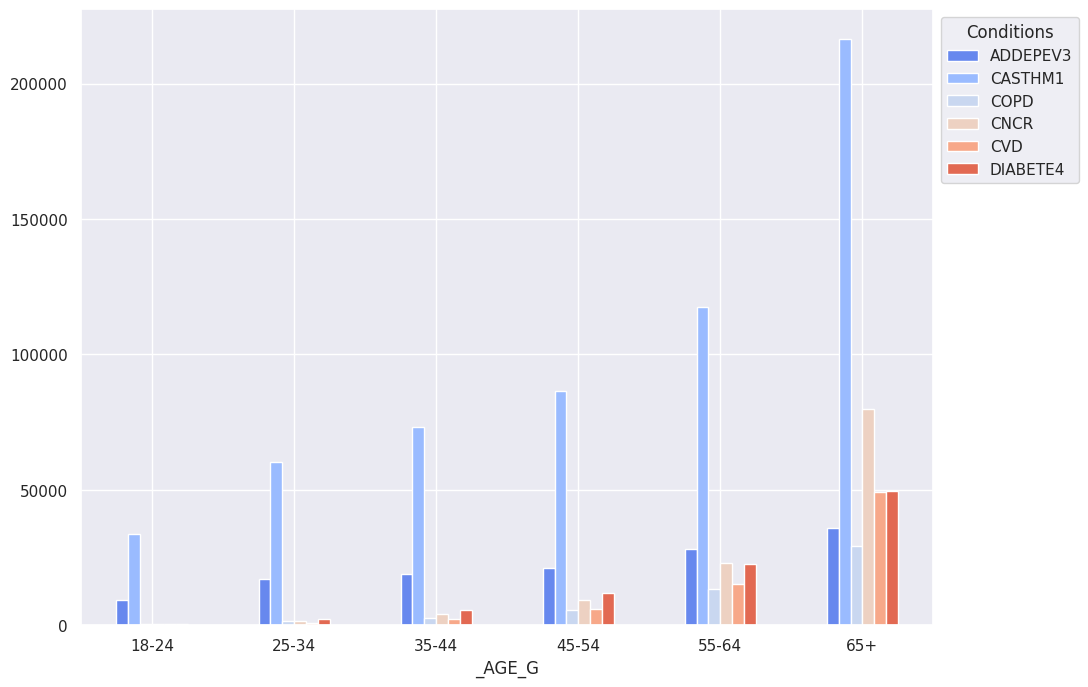

In [40]:
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
plot_cond_demographic("_AGE_G", labels)

##### (2) Chronic conditions VS Gender

In [41]:
crosstab_cond_demographic("_SEX")


 Crosstab of ADDEPEV3 vs _SEX
ADDEPEV3  _SEX       0      1
0         1.00  256740  44457
1         2.00  245117  86124

 Crosstab of _CASTHM1 vs _SEX
_CASTHM1  _SEX      0       1
0         1.00  13743  287454
1         2.00  30836  300405

 Crosstab of COPD vs _SEX
COPD  _SEX       0      1
0     1.00  278938  22259
1     2.00  300333  30908

 Crosstab of CNCR vs _SEX
CNCR  _SEX       0      1
0     1.00  248806  52391
1     2.00  265359  65882

 Crosstab of CVD vs _SEX
CVD  _SEX       0      1
0    1.00  260410  40787
1    2.00  297922  33319

 Crosstab of DIABETE4 vs _SEX
DIABETE4  _SEX       0      1
0         1.00  257672  43525
1         2.00  282352  48889


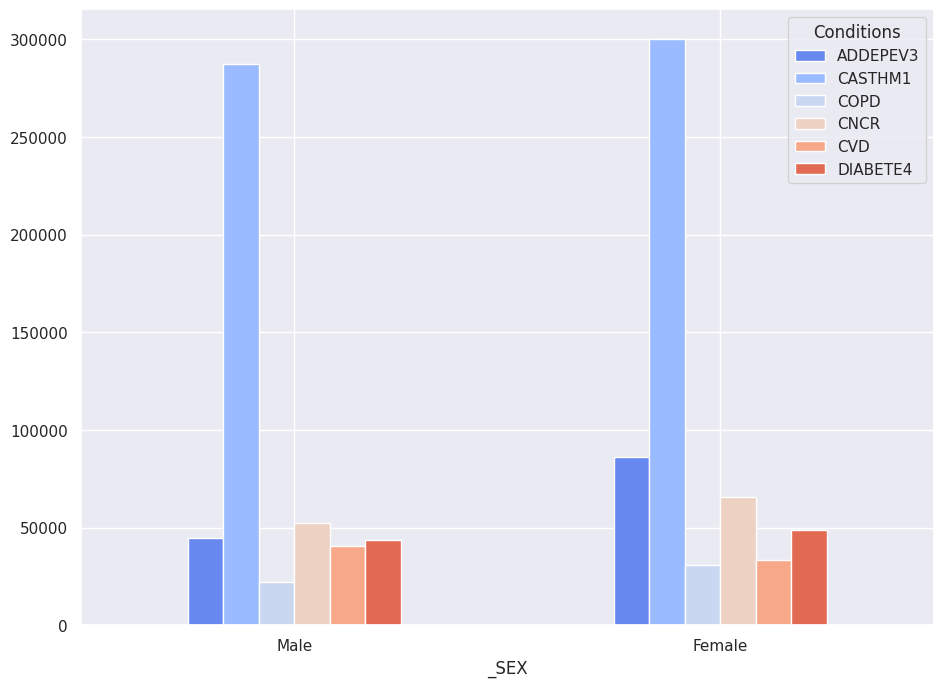

In [42]:
labels = ["Male", "Female"]
plot_cond_demographic("_SEX", labels)

##### (3) Distribution of chronic conditions VS Marital

In [43]:
crosstab_cond_demographic("MARITAL")


 Crosstab of ADDEPEV3 vs MARITAL
ADDEPEV3  MARITAL       0      1
0            1.00  279389  54216
1            2.00   60212  24466
2            3.00   58007  13304
3            4.00    7630   4075
4            5.00   77822  27232
5            6.00   16156   6707
6            9.00    2641    581

 Crosstab of _CASTHM1 vs MARITAL
_CASTHM1  MARITAL      0       1
0            1.00  18887  314718
1            2.00   8572   76106
2            3.00   6190   65121
3            4.00   1399   10306
4            5.00   7551   97503
5            6.00   1778   21085
6            9.00    202    3020

 Crosstab of COPD vs MARITAL
COPD  MARITAL       0      1
0        1.00  312420  21185
1        2.00   72782  11896
2        3.00   60270  11041
3        4.00   10093   1612
4        5.00   99311   5743
5        6.00   21407   1456
6        9.00    2988    234

 Crosstab of CNCR vs MARITAL
CNCR  MARITAL       0      1
0        1.00  267716  65889
1        2.00   67717  16961
2        3.00   48135  23

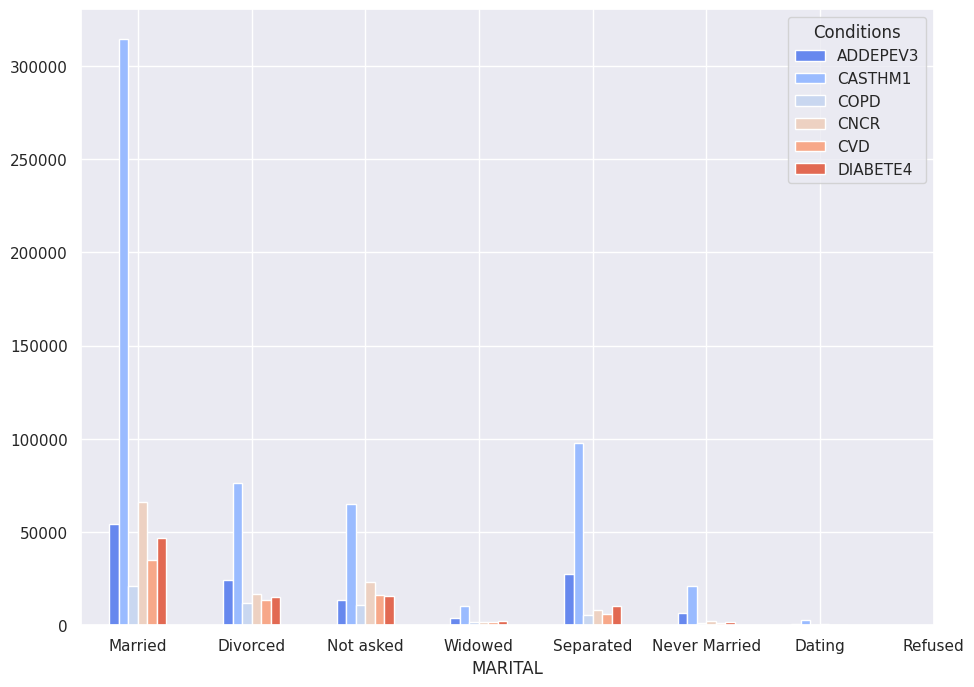

In [44]:
labels = ["Married", "Divorced", "Not asked","Widowed", "Separated", "Never Married", "Dating", "Refused"]
plot_cond_demographic("MARITAL", labels)

##### (4) Distribution of chronic conditions VS Education

In [45]:
crosstab_cond_demographic("_EDUCAG")


 Crosstab of ADDEPEV3 vs _EDUCAG
ADDEPEV3  _EDUCAG       0      1
0            1.00   24970   8638
1            2.00  126121  32534
2            3.00  136530  41569
3            4.00  213197  47678
4            9.00    1039    162

 Crosstab of _CASTHM1 vs _EDUCAG
_CASTHM1  _EDUCAG      0       1
0            1.00   4028   29580
1            2.00  11761  146894
2            3.00  14285  163814
3            4.00  14440  246435
4            9.00     65    1136

 Crosstab of COPD vs _EDUCAG
COPD  _EDUCAG       0      1
0        1.00   27497   6111
1        2.00  140766  17889
2        3.00  160979  17120
3        4.00  248910  11965
4        9.00    1119     82

 Crosstab of CNCR vs _EDUCAG
CNCR  _EDUCAG       0      1
0        1.00   28411   5197
1        2.00  131478  27177
2        3.00  144994  33105
3        4.00  208265  52610
4        9.00    1017    184

 Crosstab of CVD vs _EDUCAG
CVD  _EDUCAG       0      1
0       1.00   26968   6640
1       2.00  136611  22044
2       3.00  1

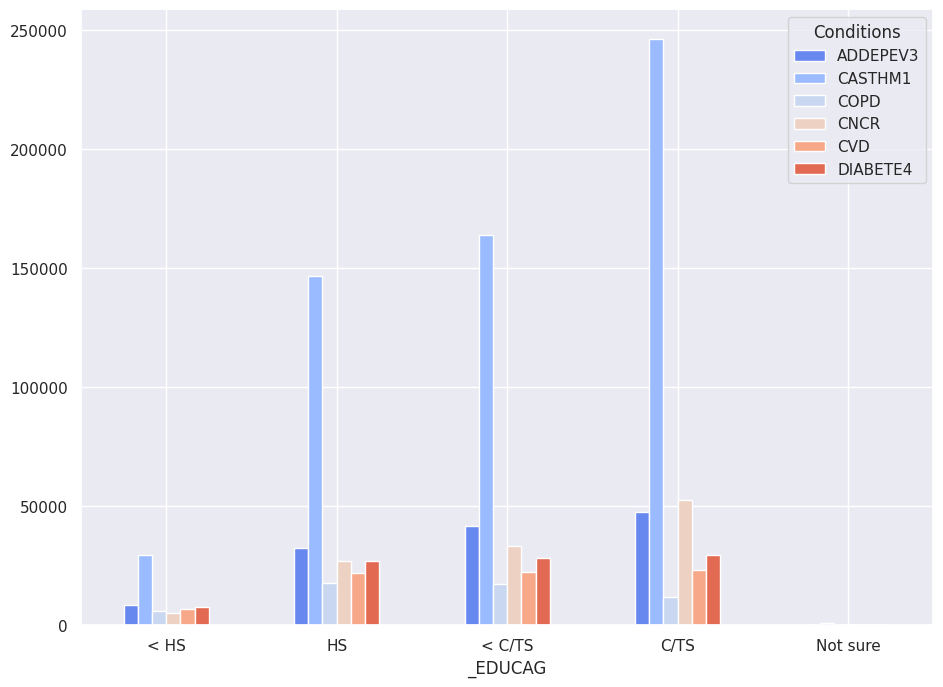

In [46]:
labels = ["< HS", "HS", "< C/TS", "C/TS", "Not sure"]
plot_cond_demographic("_EDUCAG", labels)

##### (5) Distribution of chronic conditions VS Urban/Rural Status

In [47]:
crosstab_cond_demographic("_URBSTAT")


 Crosstab of ADDEPEV3 vs _URBSTAT
ADDEPEV3  _URBSTAT       0       1
0             1.00  424596  112109
1             2.00   77261   18472

 Crosstab of _CASTHM1 vs _URBSTAT
_CASTHM1  _URBSTAT      0       1
0             1.00  37664  499041
1             2.00   6915   88818

 Crosstab of COPD vs _URBSTAT
COPD  _URBSTAT       0      1
0         1.00  493400  43305
1         2.00   85871   9862

 Crosstab of CNCR vs _URBSTAT
CNCR  _URBSTAT       0      1
0         1.00  437813  98892
1         2.00   76352  19381

 Crosstab of CVD vs _URBSTAT
CVD  _URBSTAT       0      1
0        1.00  476135  60570
1        2.00   82197  13536

 Crosstab of DIABETE4 vs _URBSTAT
DIABETE4  _URBSTAT       0      1
0             1.00  459967  76738
1             2.00   80057  15676


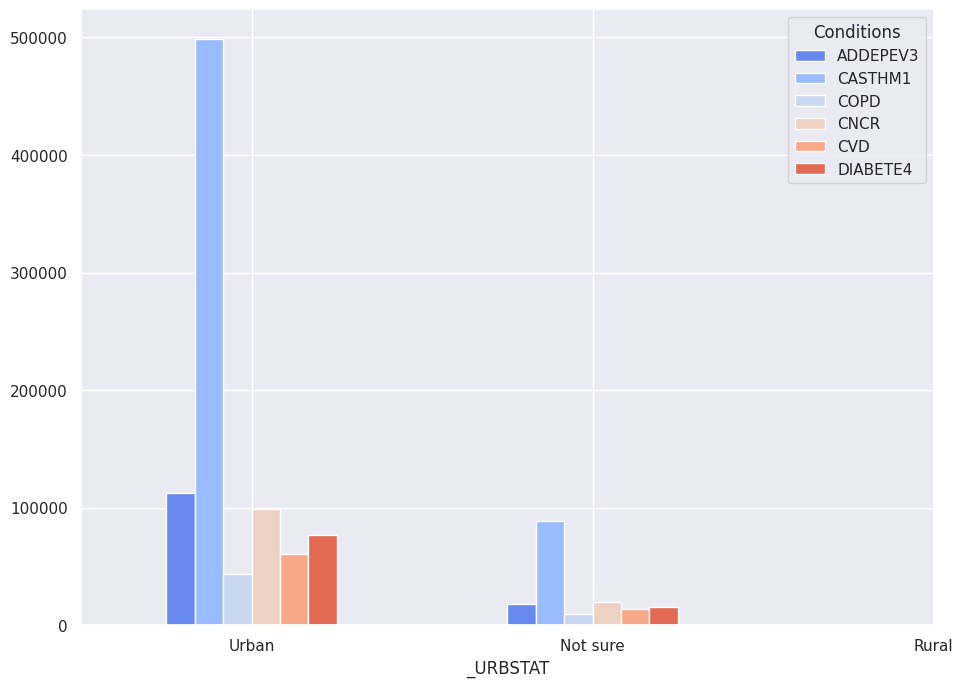

In [48]:
labels = ["Urban", "Not sure" ,"Rural"]
plot_cond_demographic("_URBSTAT", labels)

##### (6) Distribution of chronic conditions VS Income

In [49]:
crosstab_cond_demographic("INCOME2")


 Crosstab of ADDEPEV3 vs INCOME2
ADDEPEV3  INCOME2       0      1
0            1.00   10595   6888
1            2.00   12379   7361
2            3.00   18824   8530
3            4.00   27351  10322
4            5.00   45323  14382
5            6.00   59534  15787
6            7.00   75187  17507
7            8.00  115624  21356
8            9.00   32785   6752
9           10.00   13810   2466
10          11.00   13798   2027
11          77.00   31552  10836
12          99.00   45095   6367

 Crosstab of _CASTHM1 vs INCOME2
_CASTHM1  INCOME2     0       1
0            1.00  3014   14469
1            2.00  3102   16638
2            3.00  3380   23974
3            4.00  3886   33787
4            5.00  5010   54695
5            6.00  5072   70249
6            7.00  5340   87354
7            8.00  6092  130888
8            9.00  1876   37661
9           10.00   644   15632
10          11.00   532   15293
11          77.00  3936   38452
12          99.00  2695   48767

 Crosstab of COPD vs 

In [50]:
# <Greg --- could you please add a comment here?>
cf["INCOME2"] = cf["INCOME2"].replace({99:77, 9:8, 10:8, 11:8})
cf["INCOME2"].unique()

array([ 3.,  5.,  7., 77.,  8.,  6.,  4.,  2., nan,  1.])

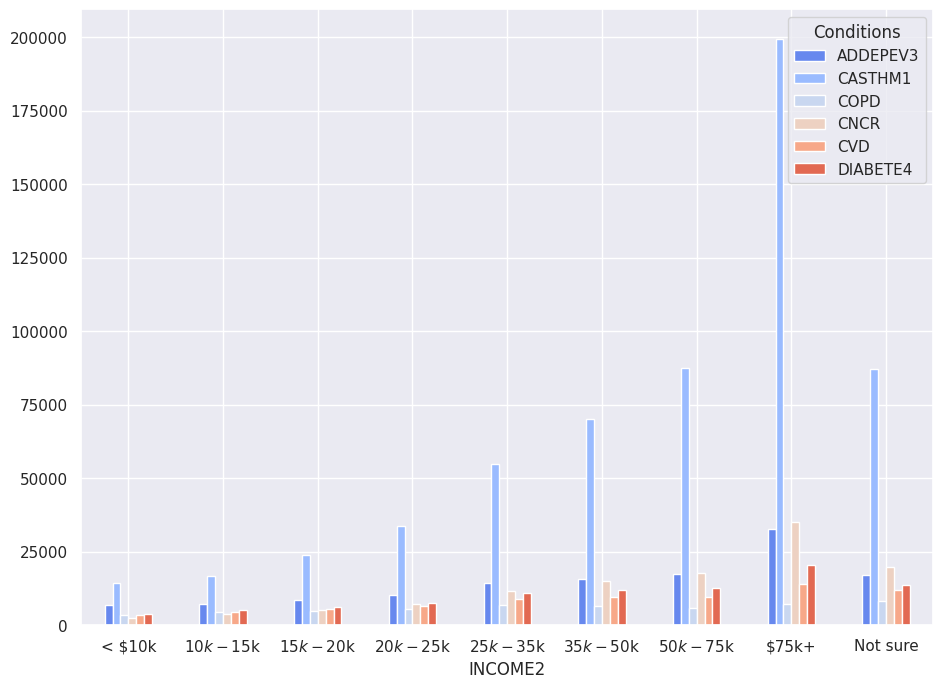

In [51]:
labels = ["< $10k", "$10k - $15k", "$15k - $20k", "$20k - $25k", "$25k - $35k", "$35k - $50k", "$50k - $75k", "$75k+", "Not sure"]
plot_cond_demographic("INCOME2", labels)

##### 6) Distribution of Chronic conditions vs  BMI

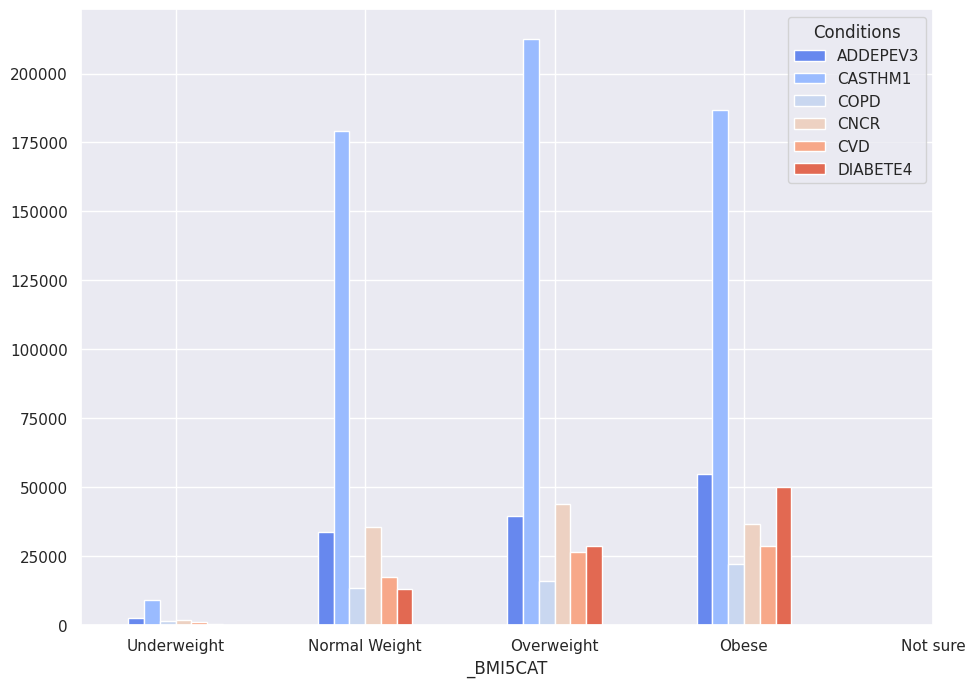

In [52]:
labels = ["Underweight", "Normal Weight", "Overweight", "Obese", "Not sure"]
plot_cond_demographic("_BMI5CAT", labels)

##### 7) Distribution of Chronic conditions vs Consumption of fruit per day

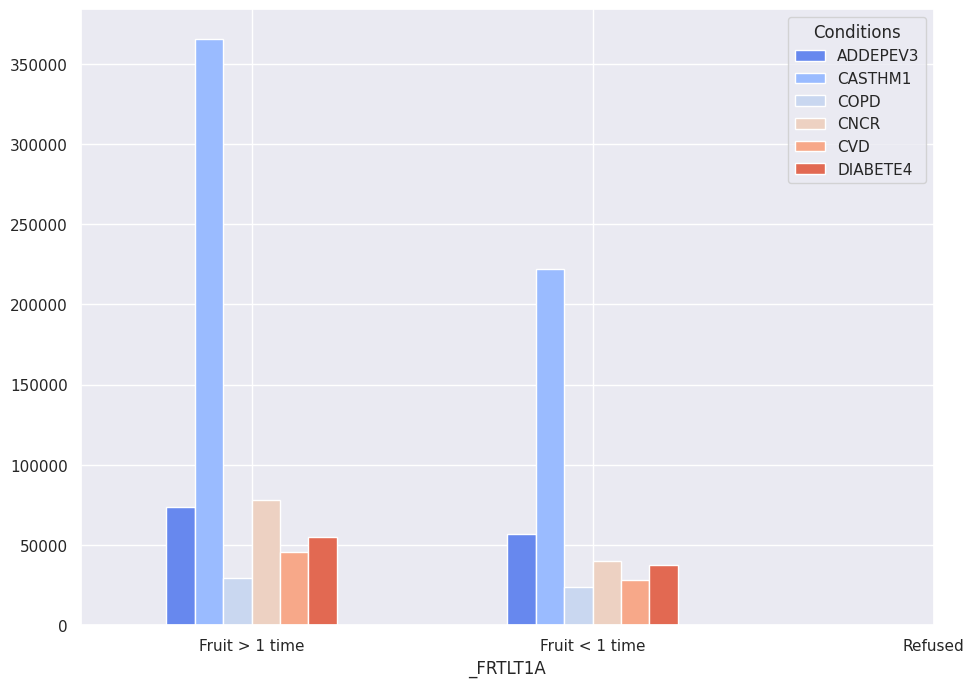

In [53]:
labels = ["Fruit > 1 time", "Fruit < 1 time", "Refused"]
plot_cond_demographic("_FRTLT1A", labels)

##### 8) Distribution of Chronic conditions vs Participate in any physical activity other than regular job

In [54]:
cf["EXERANY2"].value_counts()

1.00    479021
2.00    152548
7.00       632
9.00       237
Name: EXERANY2, dtype: int64

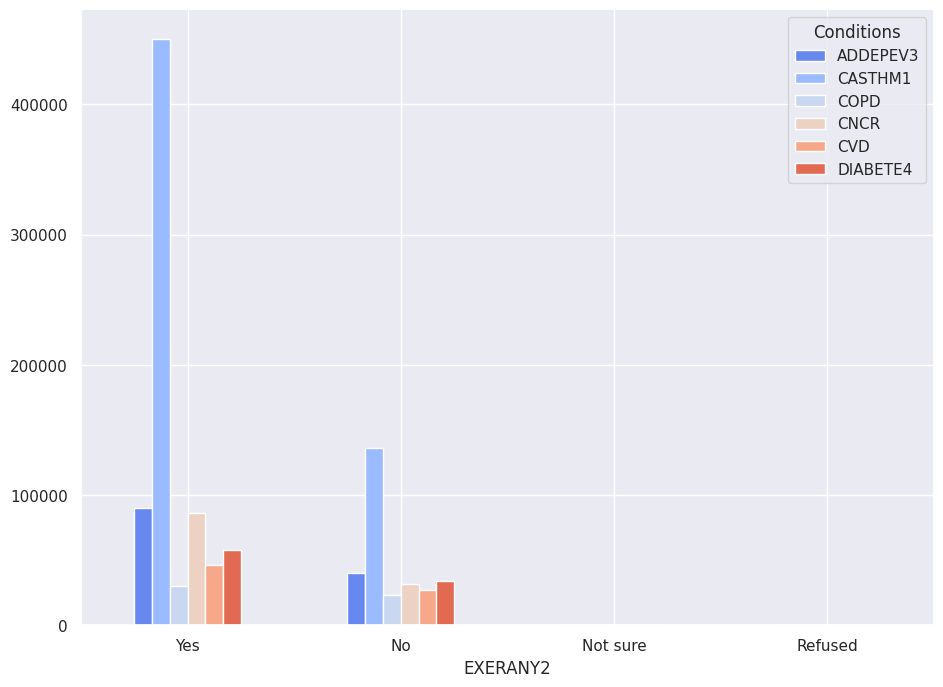

In [55]:
labels = ["Yes", "No", "Not sure", "Refused"]
plot_cond_demographic("EXERANY2", labels)

#### 2.2 Distribution of chronic conditions vs geography
##### Merging data from Region_Division_State with dataframe

In [56]:
regionCode = pd.read_excel('data/Region_Division_State.xlsx')
df = df.merge(regionCode, how='left', left_on='STATE_CODE', right_on='StateFips')

##### Analyze 'CMB_binary' value distribution by state

In [57]:
df["CMB_binary"] = df["CMB_binary"].astype(int)
cmb_binary_freq = df.groupby('Name')['CMB_binary'].mean().sort_values()
cmb_binary_freq.head(10)

Name
Hawaii          0.38
California      0.39
Alaska          0.40
New Jersey      0.40
Colorado        0.41
Illinois        0.41
Massachusetts   0.42
Iowa            0.42
Minnesota       0.43
Connecticut     0.43
Name: CMB_binary, dtype: float64

<AxesSubplot: xlabel='Name'>

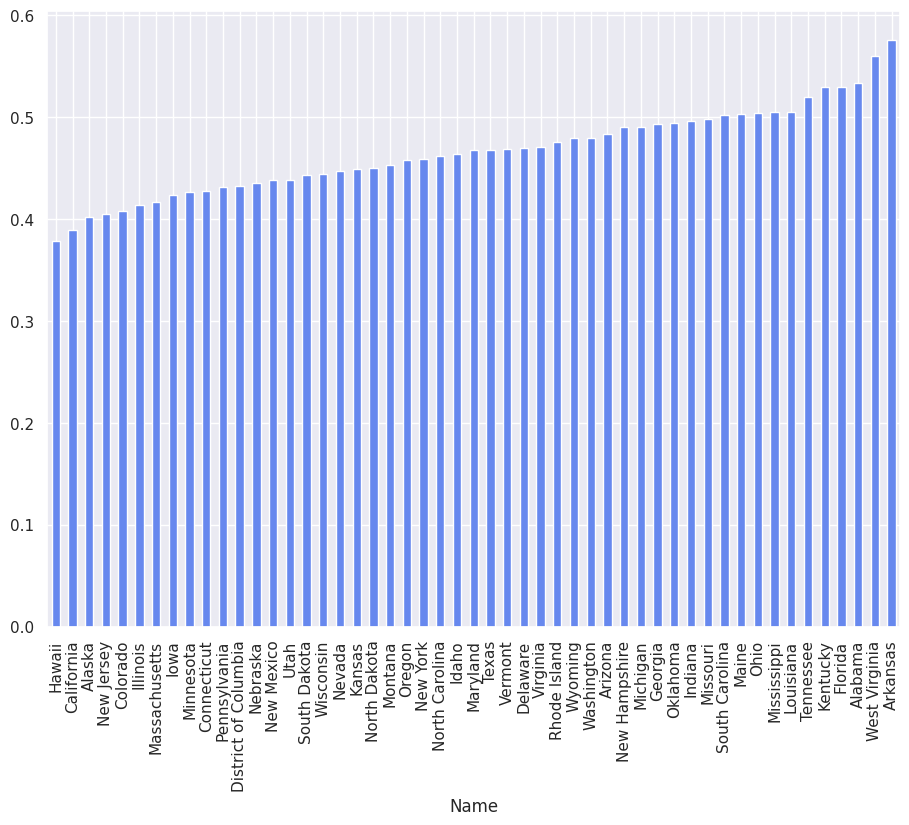

In [58]:
# plot a histogram of the data
cmb_binary_freq.plot(kind='bar')

In [59]:
cmb_binary_freq.tail(10)

Name
Maine           0.50
Ohio            0.50
Mississippi     0.50
Louisiana       0.50
Tennessee       0.52
Kentucky        0.53
Florida         0.53
Alabama         0.53
West Virginia   0.56
Arkansas        0.58
Name: CMB_binary, dtype: float64

    • From 'CMB_binary' column, we know the 10 most healthy states are: Hawaii, California, Alaska, New Jersey, Colorado, Illinois, Massachusetts, Iowa, Minnesota, Connecticut;
    • From 'CMB_binary' column, we know the 10 least healthy states are: Arkansas, West Virginia, Alabama, Florida, Kentucky, Tennessee, Louisiana, Mississippi, Ohio, Maine 

In [60]:
# cmb_multiclass_freq = df.groupby('Name')['CMB_multiclass'].value_counts(normalize=True).reset_index()
cmb_multiclass_freq = df.groupby('Name')['CMB_multiclass'].value_counts(normalize=True).rename('CMB_multiclass_freq').reset_index()
#cmb_multiclass_freq = cmb_multiclass_freq.reset_index()
cmb_multiclass_freq

,Name,CMB_multiclass,CMB_multiclass_freq
0,Alabama,0,0.47
1,Alabama,1,0.32
2,Alabama,2,0.15
3,Alabama,3+,0.06
4,Alaska,0,0.60
...,...,...,...
199,Wisconsin,3+,0.03
200,Wyoming,0,0.52
201,Wyoming,1,0.32
202,Wyoming,2,0.12


In [61]:
# Group the DataFrame by the 'b' column
groups = cmb_multiclass_freq.groupby('CMB_multiclass')

# Create a dictionary of DataFrames, with one DataFrame for each group
dict_of_dfs = {group_name: group_df for group_name, group_df in groups}

# Print each DataFrame in the dictionary
for group_name, group_df in dict_of_dfs.items():
    dict_of_dfs[group_name] = group_df.sort_values(by='CMB_multiclass_freq')
    print(f"Group {group_name}:")
    print(group_df.head())


Group 0:
          Name CMB_multiclass  CMB_multiclass_freq
0      Alabama              0                 0.47
4       Alaska              0                 0.60
8      Arizona              0                 0.52
12    Arkansas              0                 0.42
16  California              0                 0.61
Group 1:
          Name CMB_multiclass  CMB_multiclass_freq
1      Alabama              1                 0.32
5       Alaska              1                 0.28
9      Arizona              1                 0.32
13    Arkansas              1                 0.34
17  California              1                 0.28
Group 2:
          Name CMB_multiclass  CMB_multiclass_freq
2      Alabama              2                 0.15
6       Alaska              2                 0.09
10     Arizona              2                 0.12
14    Arkansas              2                 0.16
18  California              2                 0.08
Group 3+:
          Name CMB_multiclass  CMB_multiclass

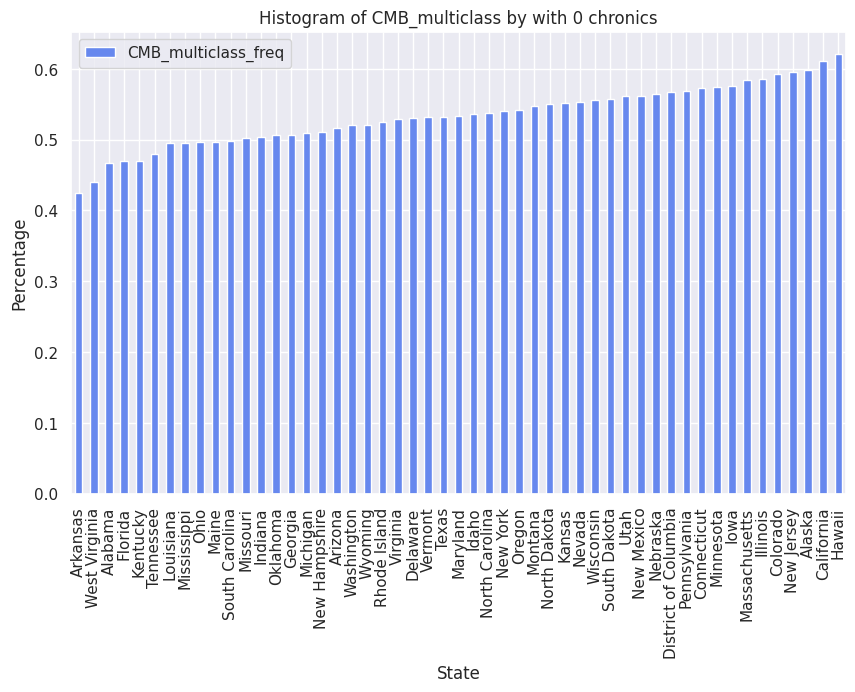

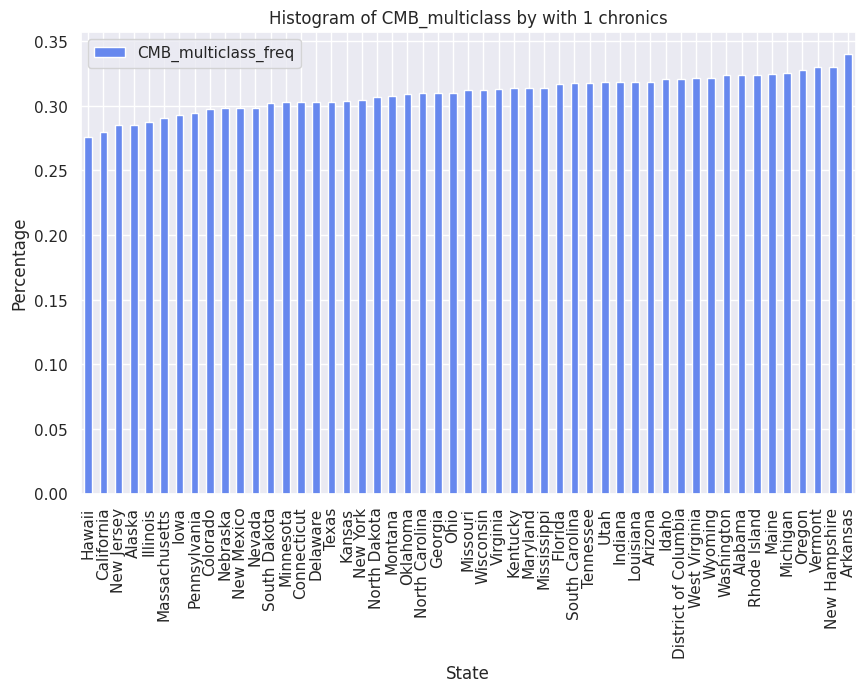

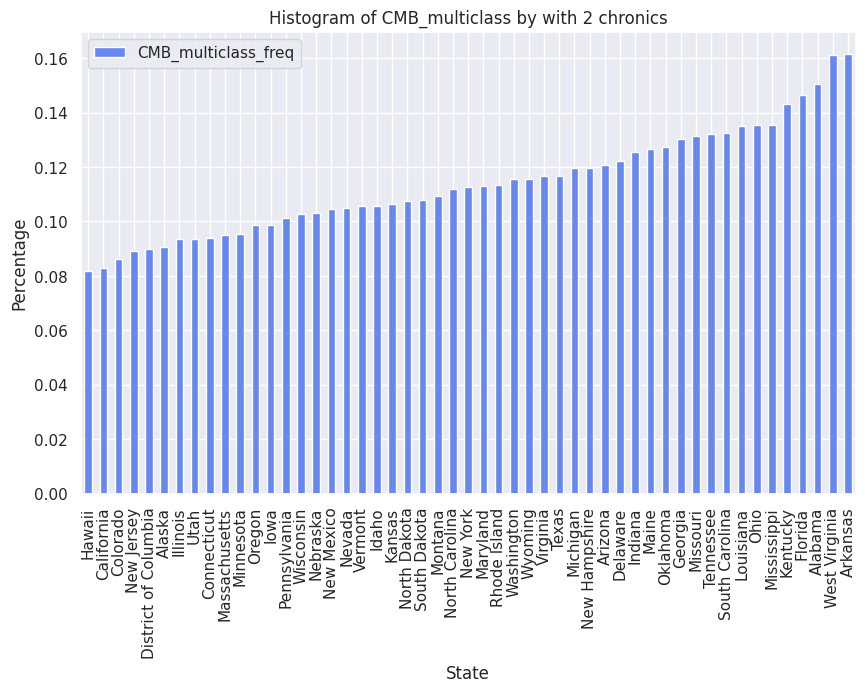

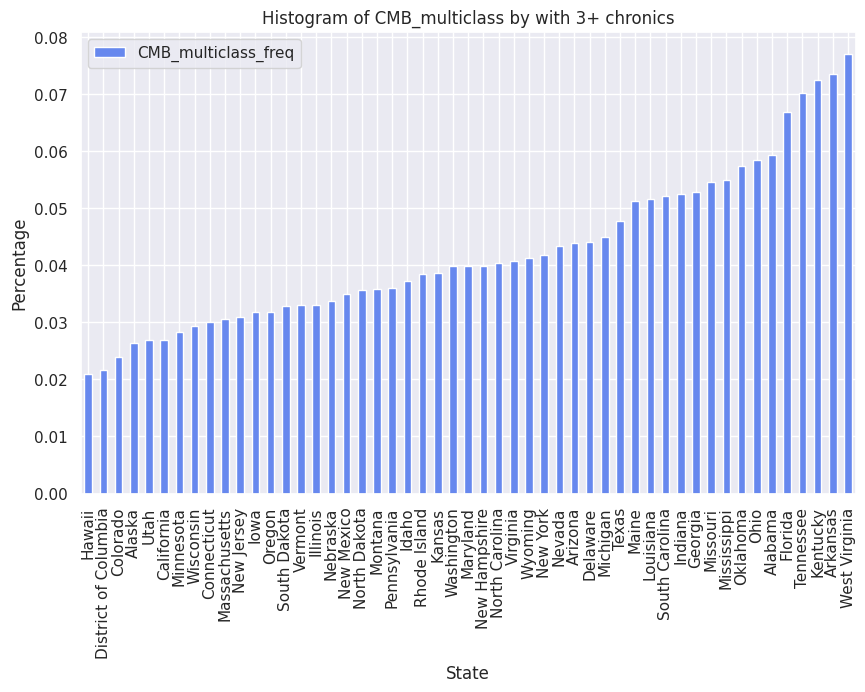

In [62]:
def plot_cmb_multi(df_name, df):
    # Assuming your dataframe is called cmb_multiclass_freq
    fig, ax = plt.subplots(figsize=(10, 6))
    df.plot(kind='bar', x='Name', y='CMB_multiclass_freq',ax=ax)

    # Set the labels for x-axis and y-axis
    ax.set_xlabel('State')
    ax.set_ylabel('Percentage')

    # Set the title for the plot
    ax.set_title(f'Histogram of CMB_multiclass by with {df_name} chronics')

    # Show the plot
    plt.show()

    
for group_name, group_df in dict_of_dfs.items():
    plot_cmb_multi(group_name, group_df)

In [63]:
group_df = dict_of_dfs[0]
print(f"Group 0")
print(group_df.head(10))
print(group_df.tail(10))

Group 0
              Name CMB_multiclass  CMB_multiclass_freq
12        Arkansas              0                 0.42
192  West Virginia              0                 0.44
0          Alabama              0                 0.47
36         Florida              0                 0.47
68        Kentucky              0                 0.47
168      Tennessee              0                 0.48
72       Louisiana              0                 0.50
96     Mississippi              0                 0.50
140           Ohio              0                 0.50
76           Maine              0                 0.50
              Name CMB_multiclass  CMB_multiclass_freq
24     Connecticut              0                 0.57
92       Minnesota              0                 0.57
60            Iowa              0                 0.58
84   Massachusetts              0                 0.58
52        Illinois              0                 0.59
20        Colorado              0                 0.59
12

In [64]:
group_df = dict_of_dfs[1]
print(f"Group 1")
print(group_df.head(10))
print(group_df.tail(10))

Group 1
              Name CMB_multiclass  CMB_multiclass_freq
45          Hawaii              1                 0.28
17      California              1                 0.28
121     New Jersey              1                 0.28
5           Alaska              1                 0.28
53        Illinois              1                 0.29
85   Massachusetts              1                 0.29
61            Iowa              1                 0.29
153   Pennsylvania              1                 0.29
21        Colorado              1                 0.30
109       Nebraska              1                 0.30
              Name CMB_multiclass  CMB_multiclass_freq
201        Wyoming              1                 0.32
189     Washington              1                 0.32
1          Alabama              1                 0.32
157   Rhode Island              1                 0.32
77           Maine              1                 0.33
89        Michigan              1                 0.33
14

In [65]:
group_df = dict_of_dfs[2]
print(f"Group 2")
print(group_df.head(10))
print(group_df.tail(10))

Group 2
                     Name CMB_multiclass  CMB_multiclass_freq
46                 Hawaii              2                 0.08
18             California              2                 0.08
22               Colorado              2                 0.09
122            New Jersey              2                 0.09
34   District of Columbia              2                 0.09
6                  Alaska              2                 0.09
54               Illinois              2                 0.09
178                  Utah              2                 0.09
26            Connecticut              2                 0.09
86          Massachusetts              2                 0.09
               Name CMB_multiclass  CMB_multiclass_freq
170       Tennessee              2                 0.13
162  South Carolina              2                 0.13
74        Louisiana              2                 0.14
142            Ohio              2                 0.14
98      Mississippi           

In [66]:
group_df = dict_of_dfs['3+']
print(f"Group 3+")
print(group_df.head(10))
print(group_df.tail(10))

Group 3+
                     Name CMB_multiclass  CMB_multiclass_freq
47                 Hawaii             3+                 0.02
35   District of Columbia             3+                 0.02
23               Colorado             3+                 0.02
7                  Alaska             3+                 0.03
179                  Utah             3+                 0.03
19             California             3+                 0.03
95              Minnesota             3+                 0.03
199             Wisconsin             3+                 0.03
27            Connecticut             3+                 0.03
87          Massachusetts             3+                 0.03
              Name CMB_multiclass  CMB_multiclass_freq
103       Missouri             3+                 0.05
99     Mississippi             3+                 0.05
147       Oklahoma             3+                 0.06
143           Ohio             3+                 0.06
3          Alabama             3+ 

    • From 'CMB_binary' column, we know the 10 most healthy states are: Hawaii, California, Alaska, New Jersey, Colorado, Illinois, Massachusetts, Iowa, Minnesota, Connecticut;
    • From 'CMB_binary' column, we know the 10 least healthy states are: Arkansas, West Virginia, Alabama, Florida, Kentucky, Tennessee, Louisiana, Mississippi, Ohio, Maine 

#### 2.4 Demographics per Region

##### 2.4.1 Adding region and state to our dataframe

In [67]:
state_region = ['Region', 'Name'] 
cf[state_region] = df[state_region]
cf.head()

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4,_AGE_G,MARITAL,_SEX,_EDUCAG,_BMI5CAT,_URBSTAT,INCOME2,RENTHOM1,EXERANY2,_FRTLT1A,Region,Name
0,0,1,0,0,0,0,6.00,2.00,2.00,1.00,3.00,1.00,3.00,2.00,2.00,1.00,South Region,Alabama
1,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,1.00,5.00,1.00,1.00,1.00,South Region,Alabama
2,0,1,0,0,0,1,6.00,3.00,2.00,4.00,4.00,1.00,7.00,1.00,1.00,1.00,South Region,Alabama
4,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,2.00,77.00,1.00,2.00,1.00,South Region,Alabama
6,0,0,1,0,0,1,6.00,2.00,1.00,4.00,4.00,2.00,7.00,1.00,1.00,1.00,South Region,Alabama


##### 2.4.2 Grouping demographics by geographic region

In [68]:
def plot_dem_by_region(demographic_cols):
    dem_by_region = cf.groupby("Region")[demographic_cols].sum()

    # Replace '_' character with space character in demographic columns
    dem_by_region.columns = [dem.replace('_', '') for dem in dem_by_region.columns]

    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(demographic_cols))
    sns.set_palette(colors)

    dem_by_region.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Demographics', bbox_to_anchor=(1,1))
    
    plt.show()

##### 2.4.3 Plotting Demographics by Region

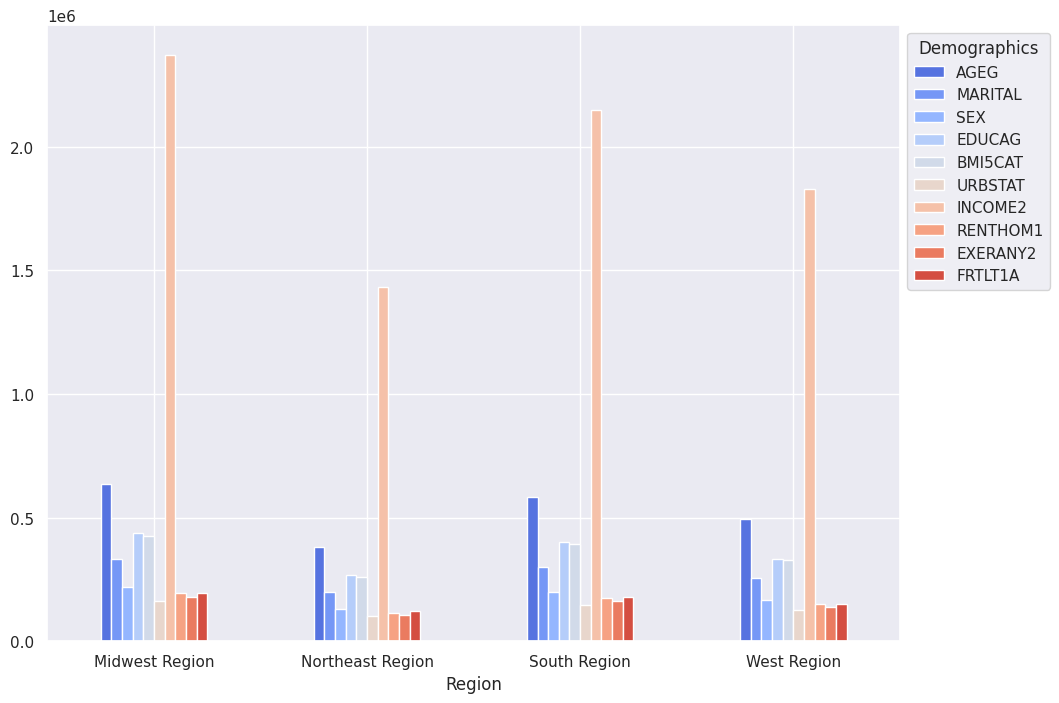

In [69]:
labels = ['South Region', 'West Region', 'Northeast Region', 'Midwest Region']
plot_dem_by_region(demographic_cols)

#### 2.5 Chronic conditions by Region

In [70]:
def plot_cond_by_region(chronic_conditions):
    cond_by_region = cf.groupby("Region")[chronic_conditions].sum()

    # Replace '_' character with space character in demographic columns
    cond_by_region.columns = [cond.replace('_', '') for cond in cond_by_region.columns]

    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    cond_by_region.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    
    plt.show()

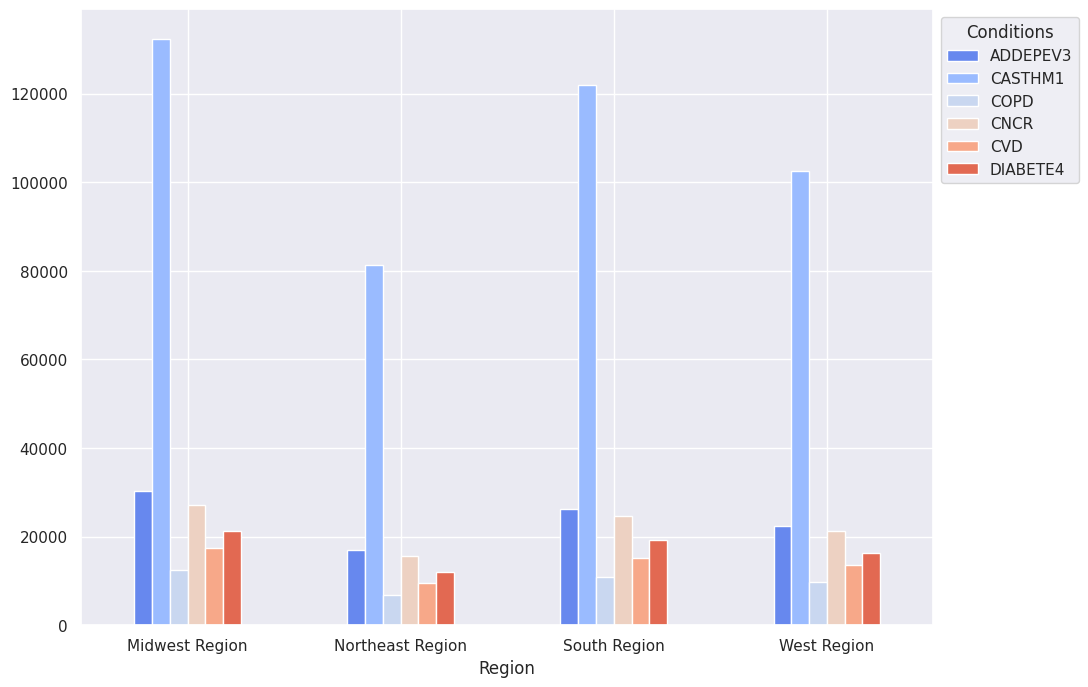

In [71]:
plot_cond_by_region(chronic_conditions)

#### 2.6 Comparing trend of chronic conditions for two years

In [72]:
cf["Year"] = df["IYEAR"]
cf["Year"] = cf["Year"].replace("b'2021'", "2021")
cf["Year"].value_counts()

2019       234233
2021       231522
b'2022'     12177
2020         9648
Name: Year, dtype: int64

In [73]:
cond_by_year = cf.groupby('Year')[chronic_conditions].sum()
cond_by_year

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4
Year,,,,,,
2019,44913,211123,19966,43770,27781,33799
2020,1909,8658,828,1666,1112,1346
2021,46798,207524,18154,41440,25556,32086
b'2022',2438,10963,892,2025,1279,1596


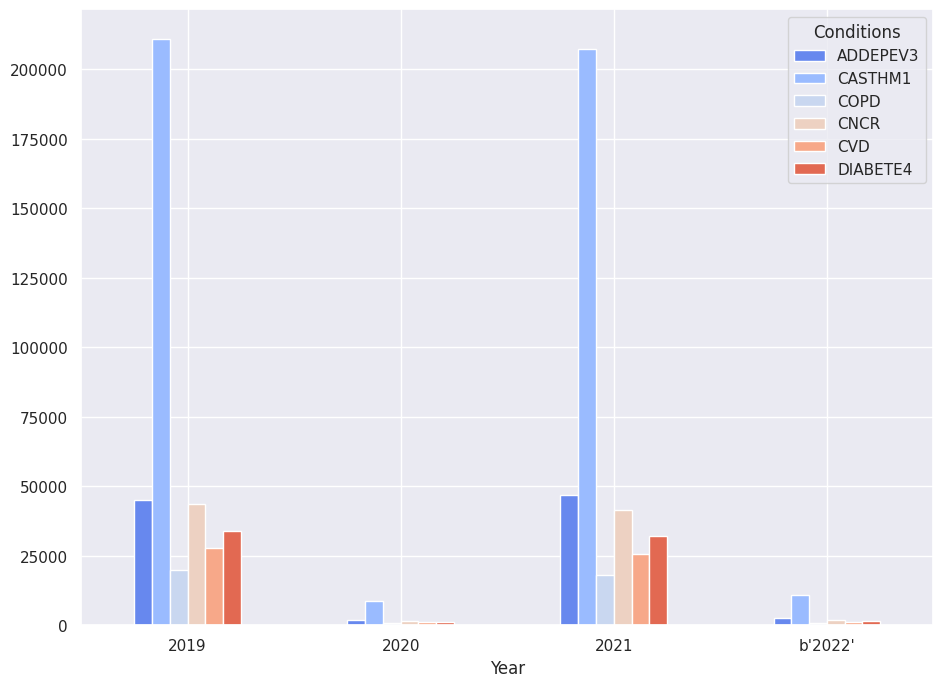

In [74]:
# Replace '_' character with space character in demographic columns
cond_by_year.columns = [cond.replace('_', '') for cond in cond_by_year.columns]

# Set the color palette for the plot
colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
sns.set_palette(colors)

cond_by_year.plot(kind='bar', rot=0)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))

plt.show()

### 3. Analysis Part 2:

#### 3.1 Feature and response space

In [75]:
feature_cols.remove('_STATE')

In [76]:
X = df[df["IYEAR"] == "b'2021'"][feature_cols]
X.head()

,INCOME2,_AGE_G,MARITAL,_SEX,_EDUCAG,_RACE,SMOKE100,_BMI5CAT,_MENT14D,_PHYS14D,_URBSTAT,VETERAN3,RENTHOM1,CHECKUP1,CHCKDNY2,EXERANY2,_FRTLT1A,_VEGLT1A,FLUSHOT7
309894,5.00,6.00,1.00,2.00,2.00,1.00,1.00,1.00,2.00,3.00,1.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,1.00
309895,3.00,6.00,3.00,2.00,2.00,2.00,2.00,3.00,1.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00
309896,7.00,5.00,1.00,2.00,2.00,1.00,2.00,4.00,2.00,1.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00
309897,4.00,6.00,1.00,1.00,1.00,7.00,2.00,3.00,1.00,3.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00
309898,6.00,6.00,1.00,1.00,3.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,1.00,2.00,2.00,2.00,2.00,1.00


In [77]:
y = df[df["IYEAR"] == "b'2021'"][response_cols]
y.head()

,CMB_binary,CMB_multiclass
309894,0,0
309895,1,2
309896,1,1
309897,1,2
309898,1,1


#### 3.2 Standardizing data

In [78]:
scaler = StandardScaler()

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = feature_cols)

X.head()

,INCOME2,_AGE_G,MARITAL,_SEX,_EDUCAG,_RACE,SMOKE100,_BMI5CAT,_MENT14D,_PHYS14D,_URBSTAT,VETERAN3,RENTHOM1,CHECKUP1,CHCKDNY2,EXERANY2,_FRTLT1A,_VEGLT1A,FLUSHOT7
0,-0.48,0.99,-0.76,0.96,-1.14,-0.44,-0.97,-2.42,0.36,1.23,-0.42,0.28,-0.47,0.54,0.08,1.61,-0.79,-0.47,-0.74
1,-0.55,0.99,0.39,0.96,-1.14,0.01,0.61,-0.01,-0.55,-0.49,-0.42,0.28,-0.47,-0.42,0.08,1.61,-0.79,2.14,0.72
2,-0.42,0.37,-0.76,0.96,-1.14,-0.44,0.61,1.19,0.36,-0.49,-0.42,0.28,-0.47,-0.42,0.08,-0.49,-0.79,-0.47,-0.74
3,-0.52,0.99,-0.76,-1.04,-2.17,2.27,0.61,-0.01,-0.55,1.23,-0.42,0.28,-0.47,-0.42,0.08,-0.49,-0.79,-0.47,-0.74
4,-0.45,0.99,-0.76,-1.04,-0.10,-0.44,-0.97,-1.21,-0.55,-0.49,2.39,0.28,-0.47,-0.42,0.08,1.61,1.27,2.14,-0.74


#### 3.3 Splitting into train and test sets

In [79]:
X_train, X_test, y_train_bin, y_test_bin, y_train_mul, y_test_mul = train_test_split(
    X, y["CMB_binary"], y["CMB_multiclass"], test_size = 0.2, random_state = 1)

y_train_mul.head()

535670    0
626546    1
410346    2
514394    2
354561    1
Name: CMB_multiclass, dtype: category
Categories (4, object): [0 < 1 < 2 < '3+']

In [80]:
type(y_train_bin)

pandas.core.series.Series

### 3.4 Classification algorithms

#### 3.4.3 Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

#### Baseline model for CMB_Binary

In [82]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     33006
           1       0.64      0.62      0.63     28389

    accuracy                           0.66     61395
   macro avg       0.66      0.66      0.66     61395
weighted avg       0.66      0.66      0.66     61395



y_test,0,1
y_pred,,
0,23087,10668
1,9919,17721


#### Hypertuning the CMB_binary model

Choosing some of the hyperparameters:
1. n_estimators : Increasing num of trees can lead to better performance, but also increases training time and memory requirements.
2. criterion : Using "Entropy" sometimes result in better perfomance while dealing with unbalanced datasets.
3. min_samples_split : Increasing this value can reduce overfitting and also lead to underfitting.
4. min_samples_leaf : Increasing this value can lead to more generalized model that performs better on unseen data.


In [83]:
clf = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=5,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Hypertuned RF Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     33006
           1       0.67      0.66      0.66     28389

    accuracy                           0.69     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.69      0.69      0.69     61395

Hypertuned RF Accuracy for CMB_binary: 0.6927762847137389


y_test,0,1
y_pred,,
0,23875,9731
1,9131,18658


##### Comparing the performance metrics for CMB_binary

Before hypertuning the random forest model for the binary classification problem of CMB data, the model had an accuracy of 0.66 with precision and recall scores of 0.68 and 0.70 for class 0, and 0.64 and 0.62 for class 1, respectively. The F1-score was 0.69 for class 0 and 0.63 for class 1.

After hypertuning the model, the accuracy improved to 0.69 with precision and recall scores of 0.71 and 0.72 for class 0, and 0.67 and 0.66 for class 1, respectively. The F1-score improved to 0.72 for class 0 and 0.66 for class 1.

In general, the model's performance improved after hypertuning with higher accuracy, precision, recall, and F1-score for both classes. The precision and recall of both classes are now more balanced, indicating that the model is better at correctly identifying both classes.

#### Baseline model for CMB_multiclass

In [84]:
# RF Classifier expects label data to be numerical
y_train_mul = y_train_mul.cat.codes
y_test_mul = y_test_mul.cat.codes

In [85]:
y_train_mul.unique()

array([0, 1, 2, 3], dtype=int8)

In [86]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Baseline RF Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.64      0.77      0.70     33006
           1       0.39      0.35      0.37     19124
           2       0.24      0.14      0.17      6770
           3       0.24      0.10      0.14      2495

    accuracy                           0.54     61395
   macro avg       0.38      0.34      0.35     61395
weighted avg       0.50      0.54      0.52     61395

Baseline RF Accuracy for CMB_multi: 0.5864646958221353


y_test,0,1,2,3
y_pred,,,,
0,25376,10715,2714,576
1,6459,6666,2851,1113
2,989,1430,916,555
3,182,313,289,251


In [88]:
clf = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=10,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Hypertuned RF Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))
# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.65      0.84      0.73     33006
           1       0.41      0.35      0.38     19124
           2       0.31      0.07      0.12      6770
           3       0.41      0.06      0.11      2495

    accuracy                           0.57     61395
   macro avg       0.44      0.33      0.33     61395
weighted avg       0.53      0.57      0.53     61395

Hypertuned RF Accuracy for CMB_multi: 0.6424953172082417


y_test,0,1,2,3
y_pred,,,,
0,27849,11829,2689,535
1,4946,6721,3474,1402
2,191,495,486,403
3,20,79,121,155


#### Comparing the performance metrics for CMB_multiclass

Before hypertuning the random forest model, the accuracy was 0.5864, whereas after hypertuning, the accuracy improved to 0.6425. This indicates that the hypertuning of the random forest model has improved its performance.

Looking at the precision and recall scores for each class, we can see that class 0 (No Chronic Condition) has the highest precision and recall scores, followed by class 1 (One Chronic Condition). Class 2 (Two Chronic Conditions) and class 3 (Three or more Chronic Conditions) have lower precision and recall scores, indicating that the model struggles to accurately predict these classes.

Comparing the confusion matrix before and after hypertuning, we can see that the hypertuned model has a higher number of correct predictions (true positives) for each class compared to the baseline model. For example, for class 0, the hypertuned model has correctly predicted 27849 instances compared to 25376 instances in the baseline model. Similarly, for class 1, the hypertuned model has correctly predicted 6721 instances compared to 6666 instances in the baseline model.

In conclusion, the hypertuned random forest model has improved the accuracy and performance of the model in predicting the number of chronic conditions a person may have.

#### 3.4.4 Gradient Boosting

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

##### Baseline Model for CMB_binary

In [90]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Baseline GB Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     33006
           1       0.68      0.66      0.67     28389

    accuracy                           0.70     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.70      0.70      0.70     61395

Baseline GB Accuracy for CMB_binary: 0.6955126638977115


y_test,0,1
y_pred,,
0,24010,9698
1,8996,18691


##### Hypertuning the model for CMB_binary

Choosing some of the parameters for tuning:
1. n_estimators : Increasing this value can improve the performance of the model with some risk of overfitting.
2. min_samples_split : Increasing this values can lead to more generalizable model that is less prone to overfitting
3. learning_rate : A smaller learning rate may lead to more accurate model but causes converging to be slow.
4. min_samples_leaf : Increasing this value can help prevent overfitting but a high value may lead to underfitting.

In [92]:
clf = GradientBoostingClassifier(n_estimators=1000,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=42)

clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Hypertuned GB Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     33006
           1       0.67      0.66      0.67     28389

    accuracy                           0.69     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.69      0.69      0.69     61395

Baseline GB Accuracy for CMB_binary: 0.6944213698183891


y_test,0,1
y_pred,,
0,23879,9634
1,9127,18755


##### Comparing performance metrics for CMB_binary

The baseline gradient boosting model for the binary CMB classification problem had an accuracy of 0.696, with a precision of 0.68, recall of 0.66 and f1-score of 0.67 for class 1. After hypertuning the model, the accuracy decreased slightly to 0.694, with a precision of 0.67, recall of 0.66 and f1-score of 0.67 for class 1.

There were no significant improvements in performance after hypertuning the gradient boosting model. 

However, the accuracy, precision, recall and f1-score for class 1 were all within a small range which indicates that the model was consistently predicting both classes with similar performance.

##### Baseline model for CMB_multiclass

In [93]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Baseline GB Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.66      0.85      0.74     33006
           1       0.41      0.36      0.38     19124
           2       0.32      0.07      0.11      6770
           3       0.38      0.09      0.15      2495

    accuracy                           0.58     61395
   macro avg       0.44      0.34      0.35     61395
weighted avg       0.53      0.58      0.54     61395

Baseline GB Accuracy for CMB_multi: 0.6493525531395065


y_test,0,1,2,3
y_pred,,,,
0,28001,11702,2536,435
1,4803,6827,3581,1458
2,152,456,464,369
3,50,139,189,233


##### Hypertuned model for CMB_multi

In [95]:
clf = GradientBoostingClassifier(n_estimators=500,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Hypertuned GB Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))
# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.66      0.83      0.74     33006
           1       0.42      0.37      0.39     19124
           2       0.32      0.09      0.15      6770
           3       0.36      0.11      0.17      2495

    accuracy                           0.58     61395
   macro avg       0.44      0.35      0.36     61395
weighted avg       0.53      0.58      0.54     61395

Hypertuned GB Accuracy for CMB_multi: 0.6417949344409154


y_test,0,1,2,3
y_pred,,,,
0,27512,11182,2426,438
1,5173,7101,3472,1318
2,256,652,638,469
3,65,189,234,270


##### Comparing performance metrics for CMB_multiclass

The baseline multiclass gradient boosting (GB) model had an accuracy of 0.649, while the hypertuned GB model had an accuracy of 0.642. The hypertuned model's accuracy is slightly lower.

Looking at the precision, recall, and f1-score for each class, we can see that the scores for the hypertuned model are similar to those of the baseline model. This suggests that the model hasn't improved much in terms of its ability to correctly identify each class.

In terms of the confusion matrix, we can see that for class 0, the hypertuned model has a slightly lower number of correct predictions compared to the baseline model, while for classes 1, 2, and 3, the hypertuned model has a slightly higher number of correct predictions. This suggests that the hypertuned model may be slightly better at predicting the minority classes, but not significantly.

Overall, the hypertuned model didn't show a significant improvement over the baseline model.